# Load data

In [90]:
import pandas as pd

data_puskesmas = pd.read_csv("review-data.csv")

data_puskesmas.head()

,reviewer_name,rating,review_text,puskesmas_name
0,Mira Diah V,5 bintang,Pelayanan di poli KIA bagus&informatif sekali....,Puskesmas Simomulyo
1,Ranitya Dewi Ayu Sadian,1 bintang,Pelayanan poli KIA lama sekali…\nKamis pagi se...,Puskesmas Simomulyo
2,Mas Bri,4 bintang,Menurut saya sudah bagus untuk mau yang mau be...,Puskesmas Simomulyo
3,Yuliasti Ika,5 bintang,"Puskesmas dengan pelayanan yang baik sekali, s...",Puskesmas Simomulyo
4,Yusup Jaya,1 bintang,"Pelayanan tambah lelet, mohon managentnya di p...",Puskesmas Simomulyo


In [91]:
try:
    %load_ext cudf.pandas
    print("cudf initialized")
except ImportError:
    print("cudf not available")

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas
cudf initialized


# Preprocess

In [92]:
data_puskesmas["rating"] = data_puskesmas["rating"].str.replace(" bintang", "")
data_puskesmas["rating"] = data_puskesmas["rating"].astype(int)

In [93]:
# remove extra spaces in the data
data_puskesmas = data_puskesmas.applymap(
    lambda x: x.strip() if isinstance(x, str) else x
)

/home/helmyl/.pyenv/versions/3.9.19/lib/python3.9/site-packages/cudf/core/dataframe.py:4625: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  warnings.warn(
/home/helmyl/.pyenv/versions/3.9.19/lib/python3.9/site-packages/cudf/pandas/fast_slow_proxy.py:30: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return fn(*args, **kwargs)


In [94]:
print(f"Null values in data_puskesmas: \n{data_puskesmas.isnull().sum()}")

Null values in data_puskesmas: 
reviewer_name        0
rating               0
review_text       4190
puskesmas_name       0
dtype: int64


In [95]:
# drop row with null values in review_text
data_puskesmas = data_puskesmas.dropna(subset=["review_text"])

print(f"Null values in data_puskesmas: \n{data_puskesmas.isnull().sum()}")

Null values in data_puskesmas: 
reviewer_name     0
rating            0
review_text       0
puskesmas_name    0
dtype: int64


In [96]:
# show 1 example of review_text each rating
for rate in data_puskesmas["rating"].unique():
    print(f"Rating {rate}:")
    print(data_puskesmas[data_puskesmas["rating"] == rate]["review_text"].iloc[0])
    print()

Rating 5:
Pelayanan di poli KIA bagus&informatif sekali. Anak saya imunisasi hari ini, meskipun anaknya rewel&tidak kooperatif tetapi tetap dilayani dgn sabar🙏 dan diberi tata cara waktu dirumah untuk penanganan post imunisasi. Terimakasih banyak untuk para nakesnya🙏 …

Rating 1:
Pelayanan poli KIA lama sekali…
Kamis pagi sekitar pukul 07.35 sy sudah di puskesmas, awalnya sy daftar di poli umum, pelayanan cepat, sekitar pukul 08.14 sy di rujuk intern di poli KIA, waktu sy sampai nomor antrian sudah 28 tetapi tdk segera dilayani,sekitar 10menit kemudian baru no 28 dipanggil kembali dan masuk. Tetapi tidak kunjung selesai smpai pukul 08.52. Lalu di panggil kembali antrian dari awal no.10, sebenarnya mekanismenya saja sdh tidak beraturan, kebetulan sy dapat rujukan intern no 36. Kira2 sy harus menunggu smpai brp lama? Sedangkan masih harus ada aktivitas setelah itu. Mohon perbaikan pelayanannya.. 1 pasien harusnya paling lama 10 menit dan continue,ini lebih dari itu dan setelah pasien kel

## Clean review text

In [97]:
import re, string
import requests

"""
For testing regex you can use this website: https://regex101.com/
"""


def rm_emoji(text):
    emoji_pattern = re.compile(
        "["
        "\U0001F600-\U0001F64F"
        "\U0001F300-\U0001F5FF"
        "\U0001F680-\U0001F6FF"
        "\U0001F1E0-\U0001F1FF"
        "\U00002500-\U00002BEF"
        "\U00002702-\U000027B0"
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "\U0001f926-\U0001f937"
        "\U00010000-\U0010ffff"
        "\u200d"
        "\u2640-\u2642"
        "\u2600-\u2B55"
        "\u23cf"
        "\u23e9"
        "\u231a"
        "\u3030"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", text)

def transform_emoji(text):
    matches = re.findall(r"\\u[0-9a-fA-F]{4}", text)
    for match in matches:
        emoji = match.encode().decode("unicode-escape")
        text = text.replace(match, emoji)

    return text


# Remove punctuations, links, hashtags, and other unnecessary characters
def rm_unnecessary(text):
    text = re.sub(r"#\S+", "", text)  # Rm hashtags
    text = re.sub(r"(\.|-|_|\,)\1+", r"\1", text)  # Rm repeating punctuations
    text = re.sub(r"([aiueo])\1{2,}", r"\1", text)  # Rm repeating vowels
    text = re.sub(r" -\S+", "", text)  # Remove words preceded by a space and a hyphen
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Rm links
    text = re.sub(r"&\w+;", "", text)  # Rm HTML entities
    text = re.sub(r"[^\x00-\x7f]", r"", text)  # Rm non-ASCII
    text = (
        text.replace("\r", "").replace("\n", " ").replace("\n", " ").lower()
    )  # Rm new lines
    stopper = (
        string.punctuation + "Ã" + "±" + "ã" + "¼" + "â" + "»" + "§"
    )  # Rm punctuation
    table = str.maketrans("", "", stopper)
    text = text.translate(table)
    text = re.sub(r"\d", "", text)  # Rm numbers
    return text


def rm_multiple_space(text):
    return re.sub("\s\s+", " ", text)

In [98]:
data_puskesmas["cleaned_review_text"] = data_puskesmas["review_text"].apply(
    lambda x: rm_multiple_space(rm_unnecessary(rm_emoji(transform_emoji(x))))
)

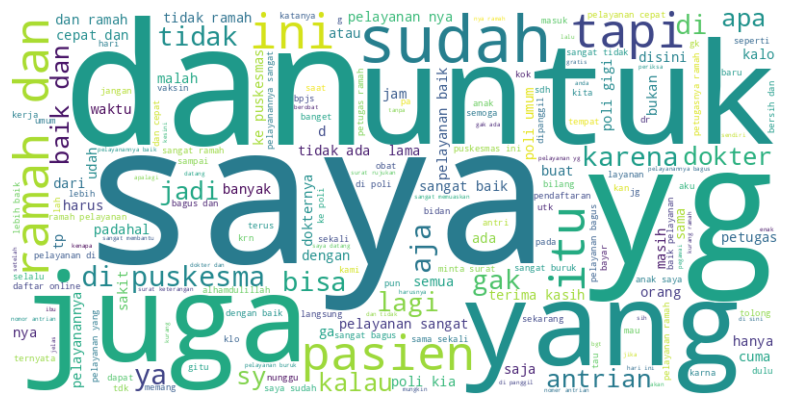

In [99]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
    " ".join(data_puskesmas["cleaned_review_text"])
)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Normalize slang

In [100]:
"""
Dictionary for Indonesian Slang Words (Bahasa Alay) were downloaded from https://github.com/nasalsabila/kamus-alay
"""

nasalsabila_indonesian_slang_words = pd.read_csv(
    f"data/colloquial-indonesian-lexicon.csv", sep=","
)

"""
Dictionary for Indonesian Slang Words (Bahasa Alay) were downloaded from https://github.com/fendiirfan/Kamus-Alay
"""

fendi_indonesian_slang_words = pd.read_csv(f"data/Kamus-Alay.csv", sep=",")

"""
Dictionary for Indonesian Slang Words (Bahasa Alay) were downloaded from https://github.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection
"""

okky_file = open(f"data/new_kamusalay.csv", "r", encoding="ISO-8859-1")
okky_indonesian_slang_words = []
for line in okky_file:
    line = line.strip().split(",")
    okky_indonesian_slang_words.append(line)
okky_indonesian_slang_words = pd.DataFrame(
    okky_indonesian_slang_words, columns=["slang", "formal"]
)

print(f"Nasa's Alay Indonesian Slang Words: {nasalsabila_indonesian_slang_words.shape}")
print(f"Fendi Indonesian Stop Words: {fendi_indonesian_slang_words.shape}")
print(f"Okky Indonesian Stop Words: {okky_indonesian_slang_words.shape}")

Nasa's Alay Indonesian Slang Words: (15006, 7)
Fendi Indonesian Stop Words: (1514, 2)
Okky Indonesian Stop Words: (15167, 2)


In [101]:
rename_dict = {"kataAlay": "slang", "kataBaik": "formal"}
fendi_indonesian_slang_words.rename(columns=rename_dict, inplace=True)

print(fendi_indonesian_slang_words.columns)

Index(['slang', 'formal'], dtype='object')


In [102]:
not_to_drop = ["slang", "formal"]
nasalsabila_indonesian_slang_words.drop(
    columns=[
        col
        for col in nasalsabila_indonesian_slang_words.columns
        if col not in not_to_drop
    ],
    inplace=True,
)

print(nasalsabila_indonesian_slang_words.columns)

Index(['slang', 'formal'], dtype='object')


In [103]:
indonesian_slang_words = pd.concat(
    [
        nasalsabila_indonesian_slang_words,
        fendi_indonesian_slang_words,
        okky_indonesian_slang_words,
    ],
    ignore_index=True,
)
indonesian_slang_words.drop_duplicates(subset=["slang"], inplace=True)
indonesian_slang_words = indonesian_slang_words.dropna()

print(f"Combined Indonesian Slang Words: {indonesian_slang_words.shape}")

Combined Indonesian Slang Words: (16346, 2)


In [104]:
from collections import defaultdict

slang_dict = defaultdict(str)
for slang, formal in zip(
    indonesian_slang_words["slang"], indonesian_slang_words["formal"]
):
    slang_dict[slang] = formal


def normalize_slang(text):
    return " ".join(
        [slang_dict[word] if word in slang_dict else word for word in text.split()]
    )

In [105]:
data_puskesmas["cleaned_review_text"] = data_puskesmas["cleaned_review_text"].apply(
    normalize_slang
)

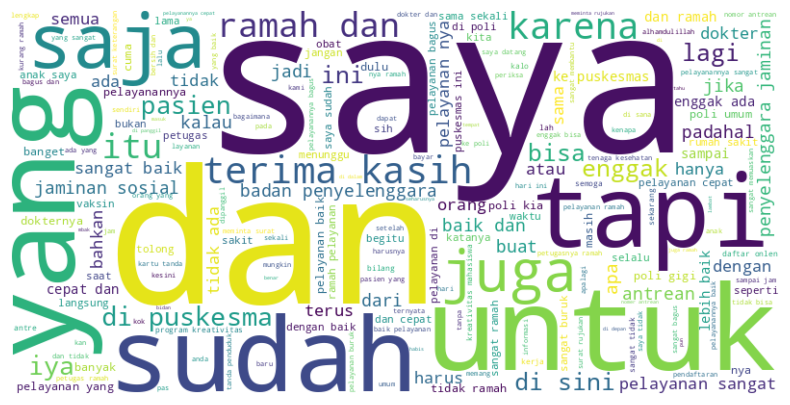

In [106]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
    " ".join(data_puskesmas["cleaned_review_text"])
)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Lemmatize

In [107]:
!pip install -q nlp-id

In [108]:
from nlp_id.lemmatizer import Lemmatizer

lemmatizer = Lemmatizer()


def lemmatize(text):
    return lemmatizer.lemmatize(text)

In [109]:
data_puskesmas["cleaned_review_text"] = data_puskesmas["cleaned_review_text"].apply(
    lemmatize
)

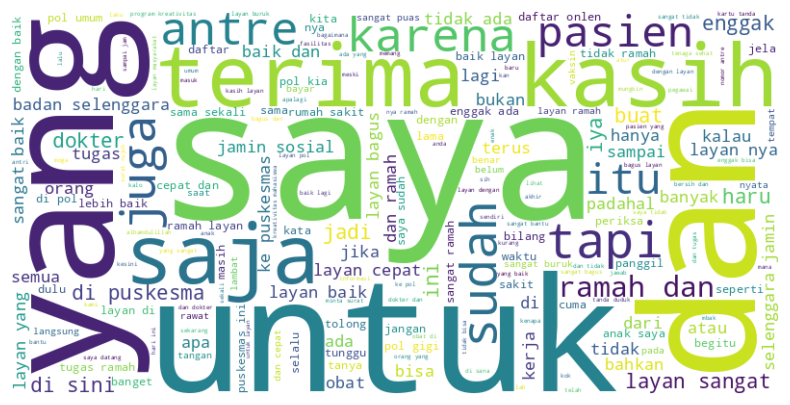

In [110]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
    " ".join(data_puskesmas["cleaned_review_text"])
)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Remove stopwords

In [111]:
"""
Stop Word List in bahasa were downloaded from https://www.kaggle.com/datasets/oswinrh/indonesian-stoplist
"""

indonesian_stopwords = []
with open(f"data/stopwordbahasa.txt", "r") as f:
    indonesian_stopwords = f.read().splitlines()

In [112]:
from nltk.corpus import stopwords
import nltk

nltk.download("stopwords")
english_stopwords = set(stopwords.words("english"))

stopwords = set(english_stopwords).union(set(indonesian_stopwords))

print(f"Total stopwords: {len(stopwords)}")

Total stopwords: 936


[nltk_data] Downloading package stopwords to /home/helmyl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [113]:
def rm_stopwords(text):
    return " ".join([word for word in text.split() if word not in stopwords])

In [114]:
data_puskesmas["cleaned_review_text"] = data_puskesmas["cleaned_review_text"].apply(
    rm_stopwords
)

In [115]:
# show 1 example of review_text each rating
for rate in data_puskesmas["rating"].unique():
    print(f"Rating {rate}:")
    print(
        data_puskesmas[data_puskesmas["rating"] == rate]["cleaned_review_text"].iloc[0]
    )
    print()

Rating 5:
layan pol kia bagusinformatif anak imunisasi anak reweltidak kooperatif layan sabar tata rumah tangan post imunisasi terima kasih nakesnya

Rating 1:
layan pol kia kamis pagi puskesmas daftar pol layan cepat rujuk intern pol kia nomor antre dilayanisekitar menit panggil masuk kunjung selesai panggil antre mekanisme atur rujuk intern tunggu aktivitas mohon layan pasien menit continueini pasien jeda tunggu pasien layan pasien padat nomer layan pasien pulg izin kantor

Rating 4:
bagus obat daftar onlen alamat website mudah cari google ikan apresiasi tukang parkir motor gerak cepat bantu pasien kunjung puskesmas harga parkir motor layan pasien daftar onlen konfirmasi daftar langsung arah duduk kursi tunggu situ monitor antre maman panggil

Rating 2:
layan jelek dokter lambat pol antri banget

Rating 3:
kunjung terbit rujuk klinik mata akses mudah layan terima kasih



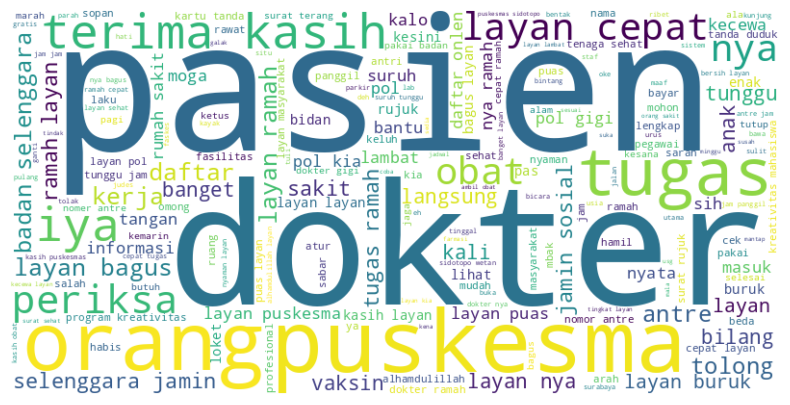

In [116]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
    " ".join(data_puskesmas["cleaned_review_text"])
)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Detect language for noise removal

In [117]:
!pip install -q fasttext-wheel

In [118]:
# https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz

import os

file_path = "cc.id.300.bin"

if not os.path.exists(file_path):
    !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.bin.gz -O cc.id.300.bin.gz -q
    !gunzip cc.id.300.bin.gz

In [119]:
import os

file_path = "lid.176.bin"

if not os.path.exists(file_path):
    !wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin -O lid.176.bin -q

In [120]:
from fasttext import FastText
import numpy as np

model_lang_detector = FastText.load_model("./lid.176.bin")


def detect_language(text):
    return model_lang_detector.predict(text)[0][0].replace("__label__", "")

In [121]:
data_puskesmas["language"] = data_puskesmas["cleaned_review_text"].apply(
    detect_language
)

print(data_puskesmas["language"].value_counts())

language
id     8527
en      695
ms      321
tr      289
sv      114
eo       86
es       79
ceb      62
eu       54
it       41
fi       38
hu       38
nl       38
jv       32
lt       31
fr       26
ca       24
la       24
pl       22
de       18
no       17
tl       16
su       12
war      12
et       11
nds      11
pt        8
bo        6
lv        6
sw        6
sr        5
hr        4
min       4
sl        4
ro        3
sk        3
sq        3
ja        2
oc        2
ur        2
cy        1
da        1
ga        1
ht        1
nn        1
Name: count, dtype: int64


In [122]:
for lang in data_puskesmas["language"].unique():
    print(f"Language {lang}:")
    print(
        data_puskesmas[data_puskesmas["language"] == lang]["cleaned_review_text"].iloc[
            0
        ]
    )
    print()

Language id:
layan pol kia bagusinformatif anak imunisasi anak reweltidak kooperatif layan sabar tata rumah tangan post imunisasi terima kasih nakesnya

Language ms:
rasai lahir disinimasyaallah banget bantu banget alhamdulillah normal adek bayi sehat pas lahir drama terima kasih tugas medis barokallah

Language en:
layan ribetbertele tele sat set awai main handphone

Language hu:
layan jelek dokter lambat pol antri banget

Language nl:
ruwet mbak antre judes layan buruk buruk

Language eu:
layan burukk

Language ca:
layan sesuai jam antre

Language tr:
layan puas

Language fi:
layan buruk vaksin sulit jarak vaksin vaksin sulit cek peduli lindung hak terima vaksin booster

Language lt:
buka ta puskesmas e

Language eo:
puskesmas oke sdmnya oke

Language es:
oke

Language ceb:
tugas bantu ramah

Language min:
pegawai ramah antre nomer eh sakit olah olah remeh

Language sv:
layan puas sesuai moto nya

Language pt:
puskesmas direnovasiagar bangun

Language tl:
maaf yaabirokrasi nya ruwet 

In [123]:
"""
ms = Malay
id = Indonesian
en = English
jv = Javanese
"""

closes_lang = ["ms", "id", "en", "jv"]

print(
    f"Rating distribution before removing non-Indonesian reviews: \n{data_puskesmas['rating'].value_counts()}"
)

data_puskesmas = data_puskesmas[data_puskesmas["language"].isin(closes_lang)]

print(
    f"Rating distribution after removing non-Indonesian reviews: \n{data_puskesmas['rating'].value_counts()}"
)

Rating distribution before removing non-Indonesian reviews: 
rating
5    6105
1    3162
4     609
2     436
3     389
Name: count, dtype: int64
Rating distribution after removing non-Indonesian reviews: 
rating
5    5366
1    2914
4     543
2     403
3     349
Name: count, dtype: int64


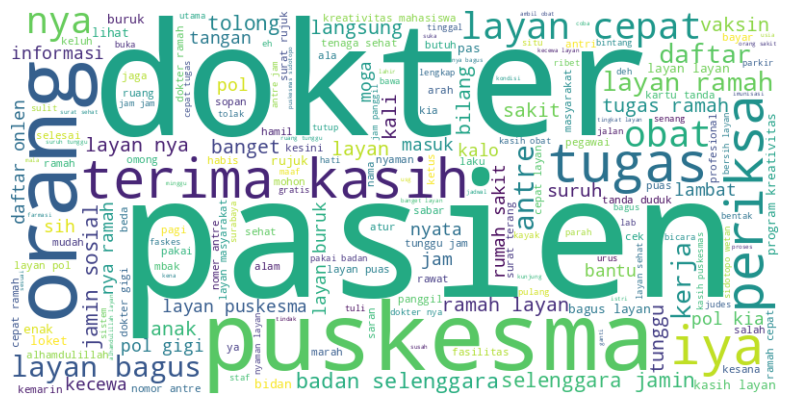

In [124]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
    " ".join(data_puskesmas["cleaned_review_text"])
)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Word Correction

In [125]:
from fasttext import FastText

model_id = FastText.load_model("cc.id.300.bin")
vocab_id = model_id.get_words()

words = list(vocab_id)
w_rank = {}

for idx, word in enumerate(words):
    w_rank[word] = idx

WORDS = w_rank

In [126]:
import re


class SpellingCorrector:
    """A class for correcting spelling errors in text."""

    def __init__(self, word_rank):
        """Initialize the SpellingCorrector with a word rank dictionary."""
        self.word_rank = word_rank
        self.letters = "abcdefghijklmnopqrstuvwxyz"

    def tokenize(self, text):
        """Tokenize the text into words."""
        return re.findall(r"\w+", text.lower())

    def word_probability(self, word):
        """Return the probability of `word`."""
        return -self.word_rank.get(word, 0)

    def correct_word(self, word):
        """Correct `word` to the most probable spelling."""
        return max(self.candidate_words(word), key=self.word_probability)

    def candidate_words(self, word):
        """Generate candidate words that may be correct spellings of `word`."""
        return (
            self.known_words([word])
            or self.known_words(self.edit_distance_one(word))
            or self.known_words(self.edit_distance_two(word))
            or [word]
        )

    def known_words(self, words):
        """Filter `words` to only include words known in the word rank dictionary."""
        return set(w for w in words if w in self.word_rank)

    def edit_distance_one(self, word):
        """Create words with an edit distance of one from `word`."""
        splits = [(word[:i], word[i:]) for i in range(len(word) + 1)]
        deletes = [L + R[1:] for L, R in splits if R]
        transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R) > 1]
        replaces = [L + c + R[1:] for L, R in splits if R for c in self.letters]
        inserts = [L + c + R for L, R in splits for c in self.letters]
        return set(deletes + transposes + replaces + inserts)

    def edit_distance_two(self, word):
        """Create words with an edit distance of two from `word`."""
        return (
            e2
            for e1 in self.edit_distance_one(word)
            for e2 in self.edit_distance_one(e1)
        )

In [127]:
spell_corrector = SpellingCorrector(WORDS)

In [128]:
from tqdm.notebook import tqdm


def correct_spelling(text):
    return " ".join([spell_corrector.correct_word(word) for word in text.split()])


tqdm.pandas()
data_puskesmas["cleaned_review_text"] = data_puskesmas[
    "cleaned_review_text"
].progress_apply(correct_spelling)

  0%|          | 0/9575 [00:00<?, ?it/s]

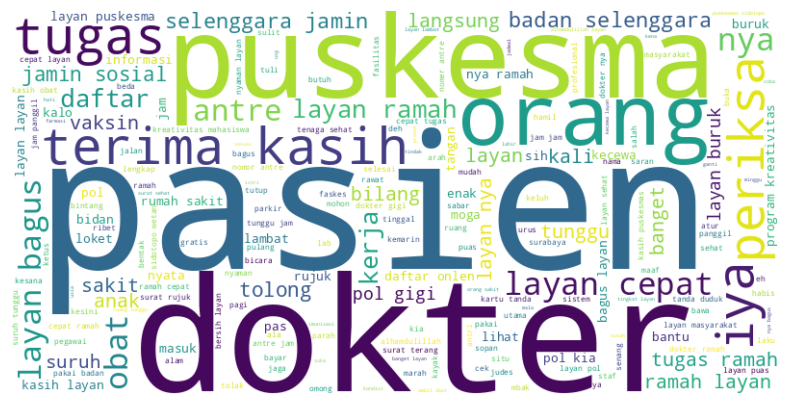

In [129]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(
    " ".join(data_puskesmas["cleaned_review_text"])
)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [130]:
# remove rows with review_text less than 10 characters
print(f"Number of rows in data_puskesmas: {data_puskesmas.shape[0]}")

data_puskesmas = data_puskesmas[data_puskesmas["cleaned_review_text"].str.len() > 10]

print(f"Number of rows in data_puskesmas: {data_puskesmas.shape[0]}")

Number of rows in data_puskesmas: 9575
Number of rows in data_puskesmas: 9026


In [131]:
# export the cleaned data
data_puskesmas.to_csv("preprocessed-review.csv", index=False)